In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format='retina'  # for hi-dpi displays

# Pattern Roto-Translation Documentation

> This notebook explains and documents the logic for generating a multispot pattern
> with arbitrary translation, rotation and different X and Y pitch.

The pattern function can be though as rigidly attached to a frame of reference passing through its center.
This frame of reference ("pattern frame of reference") rotates and translates with the pattern.


In [2]:
def rotate(x, y, angle):
    """Rotate the point (x, y) (or array of points) with respect to the origin.
    
    Arguments:
        x, y (floats or arrays): input coordinates to be transformed.
        angle (float): rotation angle in degrees. When the Y axis points
            up and the X axis points right, a positive angle result in
            a counter-clock-wise rotation.
        
    Returns:
        New coordinates or the rotated point.
    """
    if angle == 0:
        return x, y
    shape = x.shape
    assert shape == y.shape
    x_ = x.ravel()
    y_ = y.ravel()
    theta = angle * np.pi / 180
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
    v = np.vstack([x_, y_])
    xr, yr = rot_matrix @ v
    return xr.reshape(shape), yr.reshape(shape)

In [3]:
def spotmap_func(xy, pitch_xy, nspots_xy):
    """Return the spot number containing the input point(s).
    
    Arguments:
        xy (tuple of floats or arrays): coordinates on the input points.
        pitch_xy (tuple of 2 floats): X and Y pattern pitch
        nspots_xy (tuple of 2 ints): number of spots in X and Y direction.
        
    Returns:
        Return a number or an array (when passing an array as input coordinates)
        identifying the spot which contains the point. If no spot contains a point
        the value is NaN.
    """
    spotnum = [0, 0]
    for i, (v, pitch, nspots) in enumerate(zip(xy, pitch_xy, nspots_xy)):
        offset = 0 if (nspots % 2) == 0 else 0.5
        spotnum[i] = np.floor(v / pitch + offset)
        smin, smax = -(nspots // 2), (nspots // 2) + nspots % 2 - 1
        spotnum[i][(spotnum[i] < smin) + (spotnum[i] > smax)] = np.nan
    Z = spotnum[0] + spotnum[1]*ncols
    Z -= np.nanmin(Z)
    return Z

In [4]:
def spotgrid_centers(nrows, ncols, pitch_x=25, pitch_y=25,
                     center_x=0, center_y=0, rotation=0):
    """Returns centers of a grid of spots with given offset and rotation.
    
    Arguments:
        nrows, ncols (ints): number spots in the Y (nrows) and X(ncols)
            direction.
        pitch_x, pitch_y (floats): spot pitch in X and Y direction.
        center_x, center_y (floats): coordinate of the pattern center.
        rotation (float): rotation angle in degree.
    
    Returns:
        A tuple (Xm, Ym) of two 2D array containing the grid of spot centers.
    """
    xp = (np.arange(0, ncols, dtype=float) - (ncols-1)/2) * pitch_x
    yp = (np.arange(0, nrows, dtype=float) - (nrows-1)/2) * pitch_y
    Xp, Yp = np.meshgrid(xp, yp)  # spot centers in pattern space
    
    # Roto-translation to go to LCOS space
    Xm, Ym = rotate(Xp, Yp, rotation)
    Xm += center_x 
    Ym += center_y 
    return Xm, Ym

LCOS parameters:

In [5]:
LCOS_X_SIZE, LCOS_Y_SIZE, LCOS_PIX_SIZE = 800, 600, 20e-6

We defines the grid (XL, YL) of LCOS pixel centers in the LCOS frame of reference
with origin in the LCOS center and in pixel units:

In [6]:
xl = np.arange(LCOS_X_SIZE) - LCOS_X_SIZE // 2
yl = np.arange(LCOS_Y_SIZE) - LCOS_Y_SIZE // 2
YL, XL = np.mgrid[:LCOS_Y_SIZE, :LCOS_X_SIZE]
XL -= LCOS_X_SIZE // 2
YL -= LCOS_Y_SIZE // 2

By convention, the LCOS grid is centered on the LCOS pixel (400, 300): 

In [7]:
LCOS_X_SIZE//2, LCOS_Y_SIZE//2

(400, 300)

In [8]:
assert (XL[:, LCOS_X_SIZE//2] == 0).all()
assert (YL[LCOS_Y_SIZE//2] == 0).all()

Pattern parameters:

In [1]:
# Pattern shape
ncols = 3
nrows = 2

# Coordinates of the LCOS center in the pattern space
center_x = 100
center_y = 200

# Rotation of the LCOS grid versus the pattern space
rotation = 20

# Pitch for the multi-spot pattern
pitch_x = 80
pitch_y = 60

The most natural approach is working on the LCOS reference frame and moving
the pattern function with a 
[rigid transformation](https://en.wikipedia.org/wiki/Rigid_transformation) 
to the desired position and rotation.
The LCOS grid (i.e. pixels) samples this function and the pattern is obtained.
This is conceptually straightforward but, practically computing the rectangular
region for each spot is not trivial when we have a non-zero rotation.

Equivalently, we can think as the LCOS pattern is the result of sampling 
a pattern "function" defined in the pattern frame of reference
(centered on its origin and not rotated). 
To obtain an LCOS pattern with different translations and rotations,
the LCOS grid is rigidly moved to sample the
(fixed) function at different positions and orientations.
This is mathematically equivalent to the first approach
but makes it trivial to compute
the spot regions simply by using the floor function.

To calculate the rectangular regions assigned to each spot we work
in a Cartesian frame of reference rigidly attached to the centered of the pattern.
In this frame of reference the spot regions can be computed using
a simple `floor` function if the coordinates are scaled in pitch units.
The function `spotmap_func` take a pair of coordinate (x, y)
and return the spot-number which contains the point. If (x, y) does not fall
in the region of any spot NaN is returned.

The trick is feeding `spotmap_func` with the coordinates of a
rigidly transformed LCOS grid.
The (XL, YL) grid is first translated 
and then rotated with respect to its center:

In [10]:
XLtr, YLtr = rotate((XL - center_x), (YL - center_y), angle=-rotation)
Z_spots = spotmap_func((XLtr, YLtr), (pitch_x, pitch_y), (ncols, nrows))

Apart from the computing the spot regions, the crucial point of computing the multispot 
pattern is computing the distance 
of each LCOS pixel from the spot center. 

Working in the LCOS frame of reference, we can compute the 
spot (centers) coordinates as:

In [11]:
xc, yc = spotgrid_centers(nrows, ncols, pitch_x=pitch_x, pitch_y=pitch_y, 
                          center_x=center_x, center_y=center_y, rotation=rotation)

`Z_spots` (the 2D array of labeled spot regions) was computed using the inverse rigid transformation of the LCOS grid in the pattern frame of reference. The spot centers, instead, are computed with a direct rigid transformation in the LCOS frame of reference. The two transformations are equivalent, as can bee seen plotting the spot centers and the spot region (on the LCOS frame of reference):

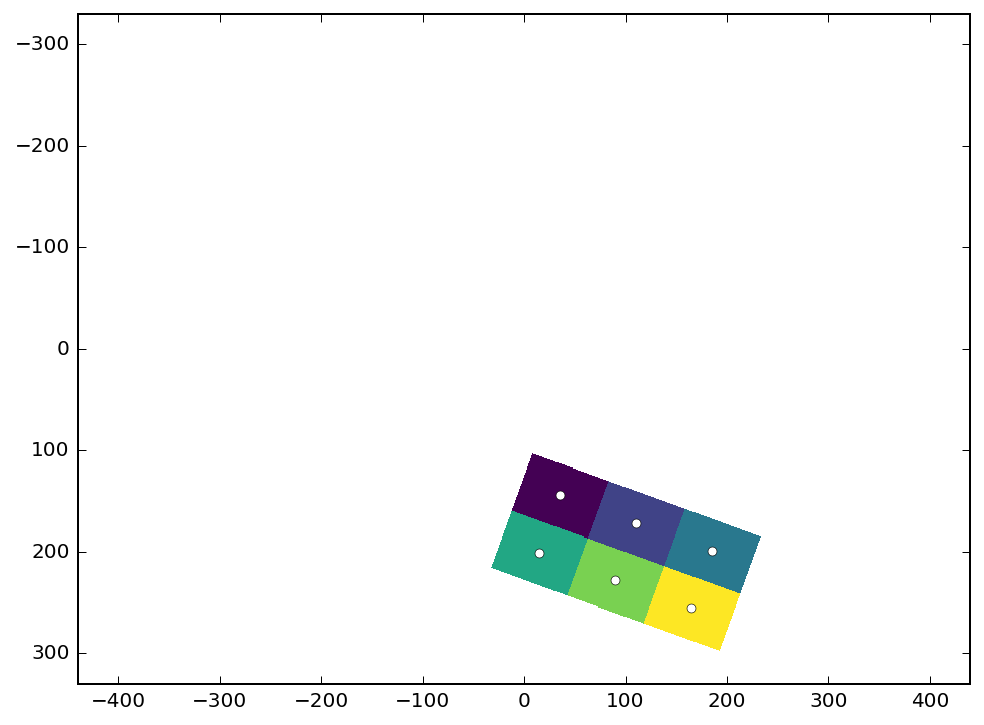

In [12]:
Z, x, y = Z_spots, xc, yc
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(Z, interpolation='none', cmap='viridis', aspect='equal', 
               extent=(-LCOS_X_SIZE/2, LCOS_X_SIZE/2, LCOS_Y_SIZE/2, -LCOS_Y_SIZE/2))
ax.scatter(x, y, color='w', edgecolors='k', lw=0.3)

The pattern is computed spot by spot. For each spot we create a mask
of pixels defining the spot region. Then, we compute the distance from
the spot center for each pixel of the region.
The correct grid to use is (XL, YL) in the LCOS frame of reference .

In [13]:
pattern = np.zeros_like(Z, dtype=float)
for ispot in range(nrows * ncols):
    mask = Z_spots == ispot
    x0, y0 = xc.ravel()[ispot], yc.ravel()[ispot]
    radius = np.sqrt((XL[mask] - x0)**2 + (YL[mask] - y0)**2)
    pattern[mask] = radius

Finally we plot the pattern:

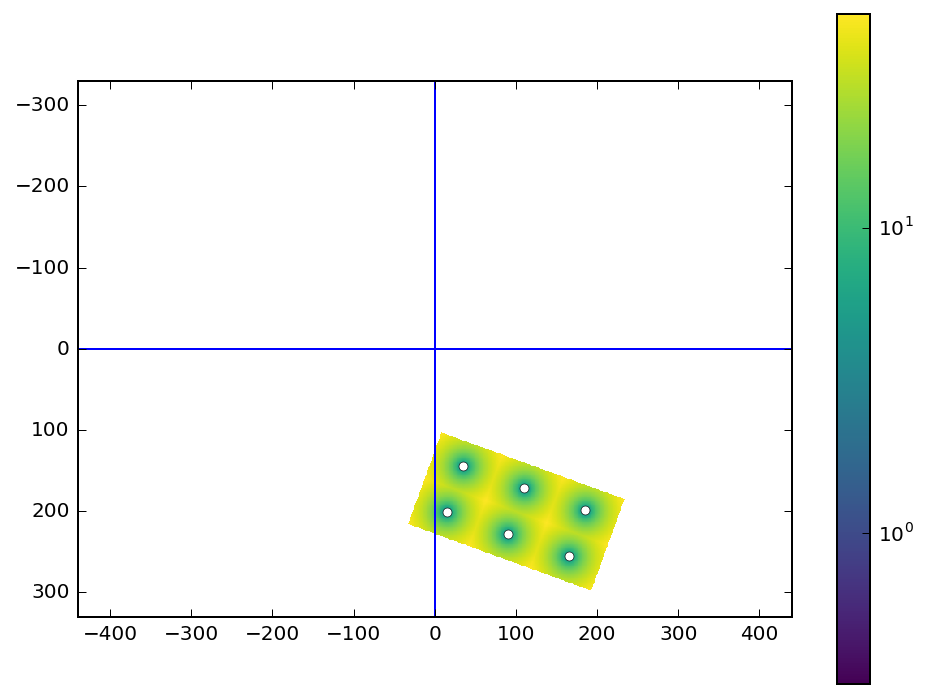

In [14]:
Z, x, y = pattern, xc, yc
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(Z, interpolation='none', cmap='viridis', aspect='equal', 
               norm=mpl.colors.LogNorm(),
               extent=(-LCOS_X_SIZE/2, LCOS_X_SIZE/2, LCOS_Y_SIZE/2, -LCOS_Y_SIZE/2))
plt.colorbar(im)
ax.scatter(x, y, color='w', edgecolors='k', lw=0.3)
ax.axhline(0); ax.axvline(0);